In [380]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio
import scipy as spy
import scipy.optimize as op
import random
import matplotlib.cm as cm #Used to display images in a specific colormap

In [381]:
# Load Training Data
path="H:/assignments/machine_learning/mex4/machine-learning-ex4/ex4/ex4data1.mat"
data=sio.loadmat(path)
X=data['X']
y=data['y']
input_layer_size  = 400  # 20x20 Input Images of Digits
hidden_layer_size = 25   # 25 hidden units
num_labels = 10    

## Visualizing the Data

In [382]:
def display_data(X,indices_to_display = None):
    """
    Function that picks 100 random rows from X, creates a 20x20 image from each,
    then stitches them together into a 10x10 grid of images, and shows it.
    """
    width, height = 20, 20
    nrows, ncols = 10, 10
    if not indices_to_display:
        indices_to_display = random.sample(range(X.shape[0]), nrows*ncols)
        
    big_picture = np.zeros((height*nrows,width*ncols))
    
    irow, icol = 0, 0
    for idx in indices_to_display:
        if icol == ncols:
            irow += 1
            icol  = 0
        iimg = X[idx].reshape(width,height).T
        big_picture[irow*height:irow*height+iimg.shape[0],icol*width:icol*width+iimg.shape[1]] = iimg
        icol += 1
    fig = plt.figure(figsize=(6,6))
    img = spy.misc.toimage( big_picture )
    plt.imshow(img,cmap = cm.Greys_r)
    plt.show()

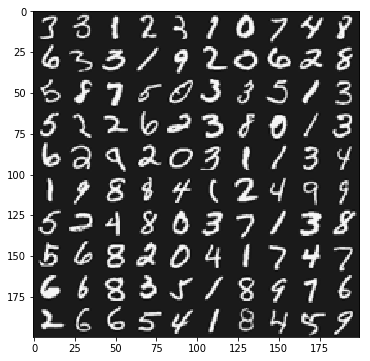

In [383]:
display_data(X)

In [384]:
plt.close('all')

In [385]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

In [386]:
def sigmoidGradient(z):
    return(sigmoid(z)*(1-sigmoid(z)))

## Loading Parameters

In [387]:
path="H:/assignments/machine_learning/mex4/machine-learning-ex4/ex4/ex4weights.mat"
wgt=sio.loadmat(path)
theta1=wgt['Theta1']
theta2=wgt['Theta2']
# Unroll parameters
theta = np.r_[theta1.ravel(), theta2.ravel()]
theta.shape

(10285,)

### Computing Cost

In [388]:
def nn_cost_function(params, input_layer_size, hidden_layer_size,num_labels, X, y, lam):
    theta1=params[0:(hidden_layer_size*(input_layer_size+1))].reshape(hidden_layer_size,(input_layer_size+1))
    theta2=params[(hidden_layer_size*(input_layer_size+1)):].reshape(num_labels,(hidden_layer_size+1))
    m=X.shape[0]
    XX=np.c_[np.ones((X.shape[0],1)),X]
    z1=XX.dot(theta1.T)
    a2=sigmoid(z1)
    a2=np.c_[np.ones((a2.shape[0],1)),a2]
    a3=sigmoid(a2.dot(theta2.T))
    h3=a3
    y=pd.get_dummies(y.ravel()).as_matrix()
    s0=-np.multiply(y,np.log(h3))
    s1=-np.multiply((1-y),np.log(1-h3))
    s_reg=lam*(np.sum(np.square(theta1[1:]))+np.sum(np.square(theta2[1:])))/(2*m)
    J=np.sum(s0+s1)/m+s_reg    
    return J
  


### Forward and Backward Propgation

In [389]:
def backprop_nn(params, input_layer_size, hidden_layer_size,num_labels, X, y, lam):
    theta1=params[0:(hidden_layer_size*(input_layer_size+1))].reshape(hidden_layer_size,(input_layer_size+1))
    theta2=params[(hidden_layer_size*(input_layer_size+1)):].reshape(num_labels,(hidden_layer_size+1))
    m=X.shape[0]
    XX=np.c_[np.ones((X.shape[0],1)),X]
    z1=XX.dot(theta1.T)
    a2=sigmoid(z1)
    a2=np.c_[np.ones((a2.shape[0],1)),a2]
    a3=sigmoid(a2.dot(theta2.T))
    h3=a3
    y=pd.get_dummies(y.ravel()).as_matrix()
    s0=-np.multiply(y,np.log(h3))
    s1=-np.multiply((1-y),np.log(1-h3))
    s_reg=lam*(np.sum(np.square(theta1[1:]))+np.sum(np.square(theta2[1:])))/(2*m)
    J=np.sum(s0+s1)/m+s_reg
#     print(J)
    # Gradients
    d3 = h3 - y # 5000x10
    d2 = np.multiply(theta2[:,1:].T.dot(d3.T),sigmoidGradient(z1).T) # 25x10 *10x5000 * 25x5000 = 25x5000
    
    delta1 = d2.dot(XX) # 25x5000 * 5000x401 = 25x401
    delta2 = d3.T.dot(a2) # 10x5000 *5000x26 = 10x26
    
    theta1_ = np.c_[np.ones((theta1.shape[0],1)),theta1[:,1:]]
    theta2_ = np.c_[np.ones((theta2.shape[0],1)),theta2[:,1:]]
    
    theta1_grad = delta1/m + (theta1_*lam)/m
    theta2_grad = delta2/m + (theta2_*lam)/m
#     print(theta1_grad.shape,theta2_grad.shape)
    theta_nw = np.concatenate((np.ravel(delta1), np.ravel(delta2)))
    return theta_nw 

In [391]:
lam=0
J= nn_cost_function(theta, input_layer_size, hidden_layer_size,num_labels, X, y, lam)
theta_nw = grads_nn(theta, input_layer_size, hidden_layer_size,num_labels, X, y, lam)
J,theta_nw.shape

(0.28762916516131892, (10285,))

In [392]:
lam=1
J= nn_cost_function(theta, input_layer_size, hidden_layer_size,num_labels, X, y, lam)
theta_nw = grads_nn(theta, input_layer_size, hidden_layer_size,num_labels, X, y, lam)
J,theta_nw.shape


(0.37904640005669177, (10285,))

### Random Initilization

In [393]:
params = (np.random.random(size=hidden_layer_size * (input_layer_size + 1) + num_labels * (hidden_layer_size + 1)) - 0.5) * 0.25
params.shape

(10285,)

### Optimizing using scipy minimize

In [394]:
lam=1
Result = op.minimize(fun = nn_cost_function, x0 = params ,\
                     args = (input_layer_size, hidden_layer_size,num_labels, X, y, lam),method = 'TNC', jac = backprop_nn);
opt_theta=Result .x

In [395]:
opt_theta.shape

(10285,)

### Predicting  accuracy on training set

In [396]:
def predict_nn(theta1,theta2,X):
    layer1_act=sigmoid(np.dot(X,theta1.T))
    layer1_act=np.c_[np.ones((layer1_act.shape[0],1)),layer1_act]
    layer2_act=sigmoid(np.dot(layer1_act,theta2.T))
    return (np.argmax(layer2_act, axis=1)+1)

In [397]:
theta1=opt_theta[0:(hidden_layer_size*(input_layer_size+1))].reshape(hidden_layer_size,(input_layer_size+1))
theta2=opt_theta[(hidden_layer_size*(input_layer_size+1)):].reshape(num_labels,(hidden_layer_size+1))
XX=np.c_[np.ones((X.shape[0],1)),X]
pred=predict_nn(theta1,theta2,XX)
print('Training set accuracy: {} %'.format(np.mean(pred == y.ravel())*100))

Training set accuracy: 97.04 %


### Viewing hidden layer parameters

In [398]:
def displayHiddenLayer(myTheta):
    """
    Function that takes slices of the first Theta matrix (that goes from
    the input layer to the hidden layer), removes the bias unit, and reshapes
    it into a 20x20 image, and shows it
    """
    #remove bias unit:
    myTheta = myTheta[:,1:]
    assert myTheta.shape == (25,400)
    
    width, height = 20, 20
    nrows, ncols = 5, 5
        
    big_picture = np.zeros((height*nrows,width*ncols))
    
    irow, icol = 0, 0
    for row in myTheta:
        if icol == ncols:
            irow += 1
            icol  = 0
        #add bias unit back in?
        iimg =(np.insert(row,0,1))[1:].reshape(width,height).T
        big_picture[irow*height:irow*height+iimg.shape[0],icol*width:icol*width+iimg.shape[1]] = iimg
        icol += 1
    fig = plt.figure(figsize=(6,6))
    img = spy.misc.toimage( big_picture )
    plt.imshow(img,cmap = cm.Greys_r)
    plt.show()

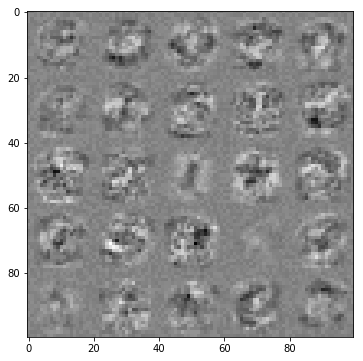

In [399]:

theta1=opt_theta[0:(hidden_layer_size*(input_layer_size+1))].reshape(hidden_layer_size,(input_layer_size+1))
displayHiddenLayer(theta1)

In [372]:
plt.close('all')